In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from processing.postprocessing import train_test_df_split, train_test_handling, emg_augmentation
from models.lstm import LSTM
import seaborn as sb

sb.set()

In [2]:
df = pd.read_csv('subject_10.csv')

In [3]:
%%time
train_df, val_df = train_test_df_split(df, 5)
train_df, test_df = train_test_df_split(train_df, 4)

CPU times: user 366 ms, sys: 2.07 ms, total: 368 ms
Wall time: 368 ms


In [4]:
len(train_df)

6580

In [5]:
train_df = emg_augmentation(train_df, 25, 0.5, 4)

100%|██████████| 25/25 [00:06<00:00,  3.81it/s]


In [6]:
len(train_df)

89740

In [7]:
X_train, y_train, train_trials, train_type, \
    X_val, y_val, val_trials, val_type = train_test_handling(train_df, val_df)

In [8]:
X_train, y_train, train_trials, train_type, \
    X_test, y_test, test_trials, test_type = train_test_handling(train_df, test_df)

In [9]:
model = LSTM(
    window_size=20,
    hidden_size=128,
    batch_size=10,
    output_size=2
)

model.init_data(X_train, y_train, X_val, y_val)

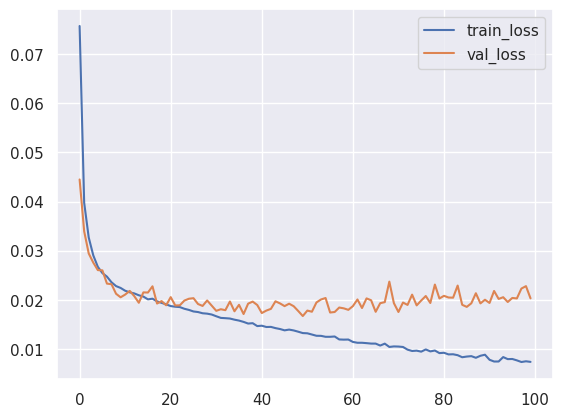

In [10]:
model.train(verbose=True, epochs=100)

In [11]:
import torch

window_size = 20
X_test = X_test.reshape(-1, window_size, 8)
y_test = y_test.reshape(-1, window_size, 2)

test_data = torch.FloatTensor(X_test)
test_pred = torch.FloatTensor(y_test)
test_loader = model.create_dataloader(test_data, test_pred, batch_size=10, shuffle=False)

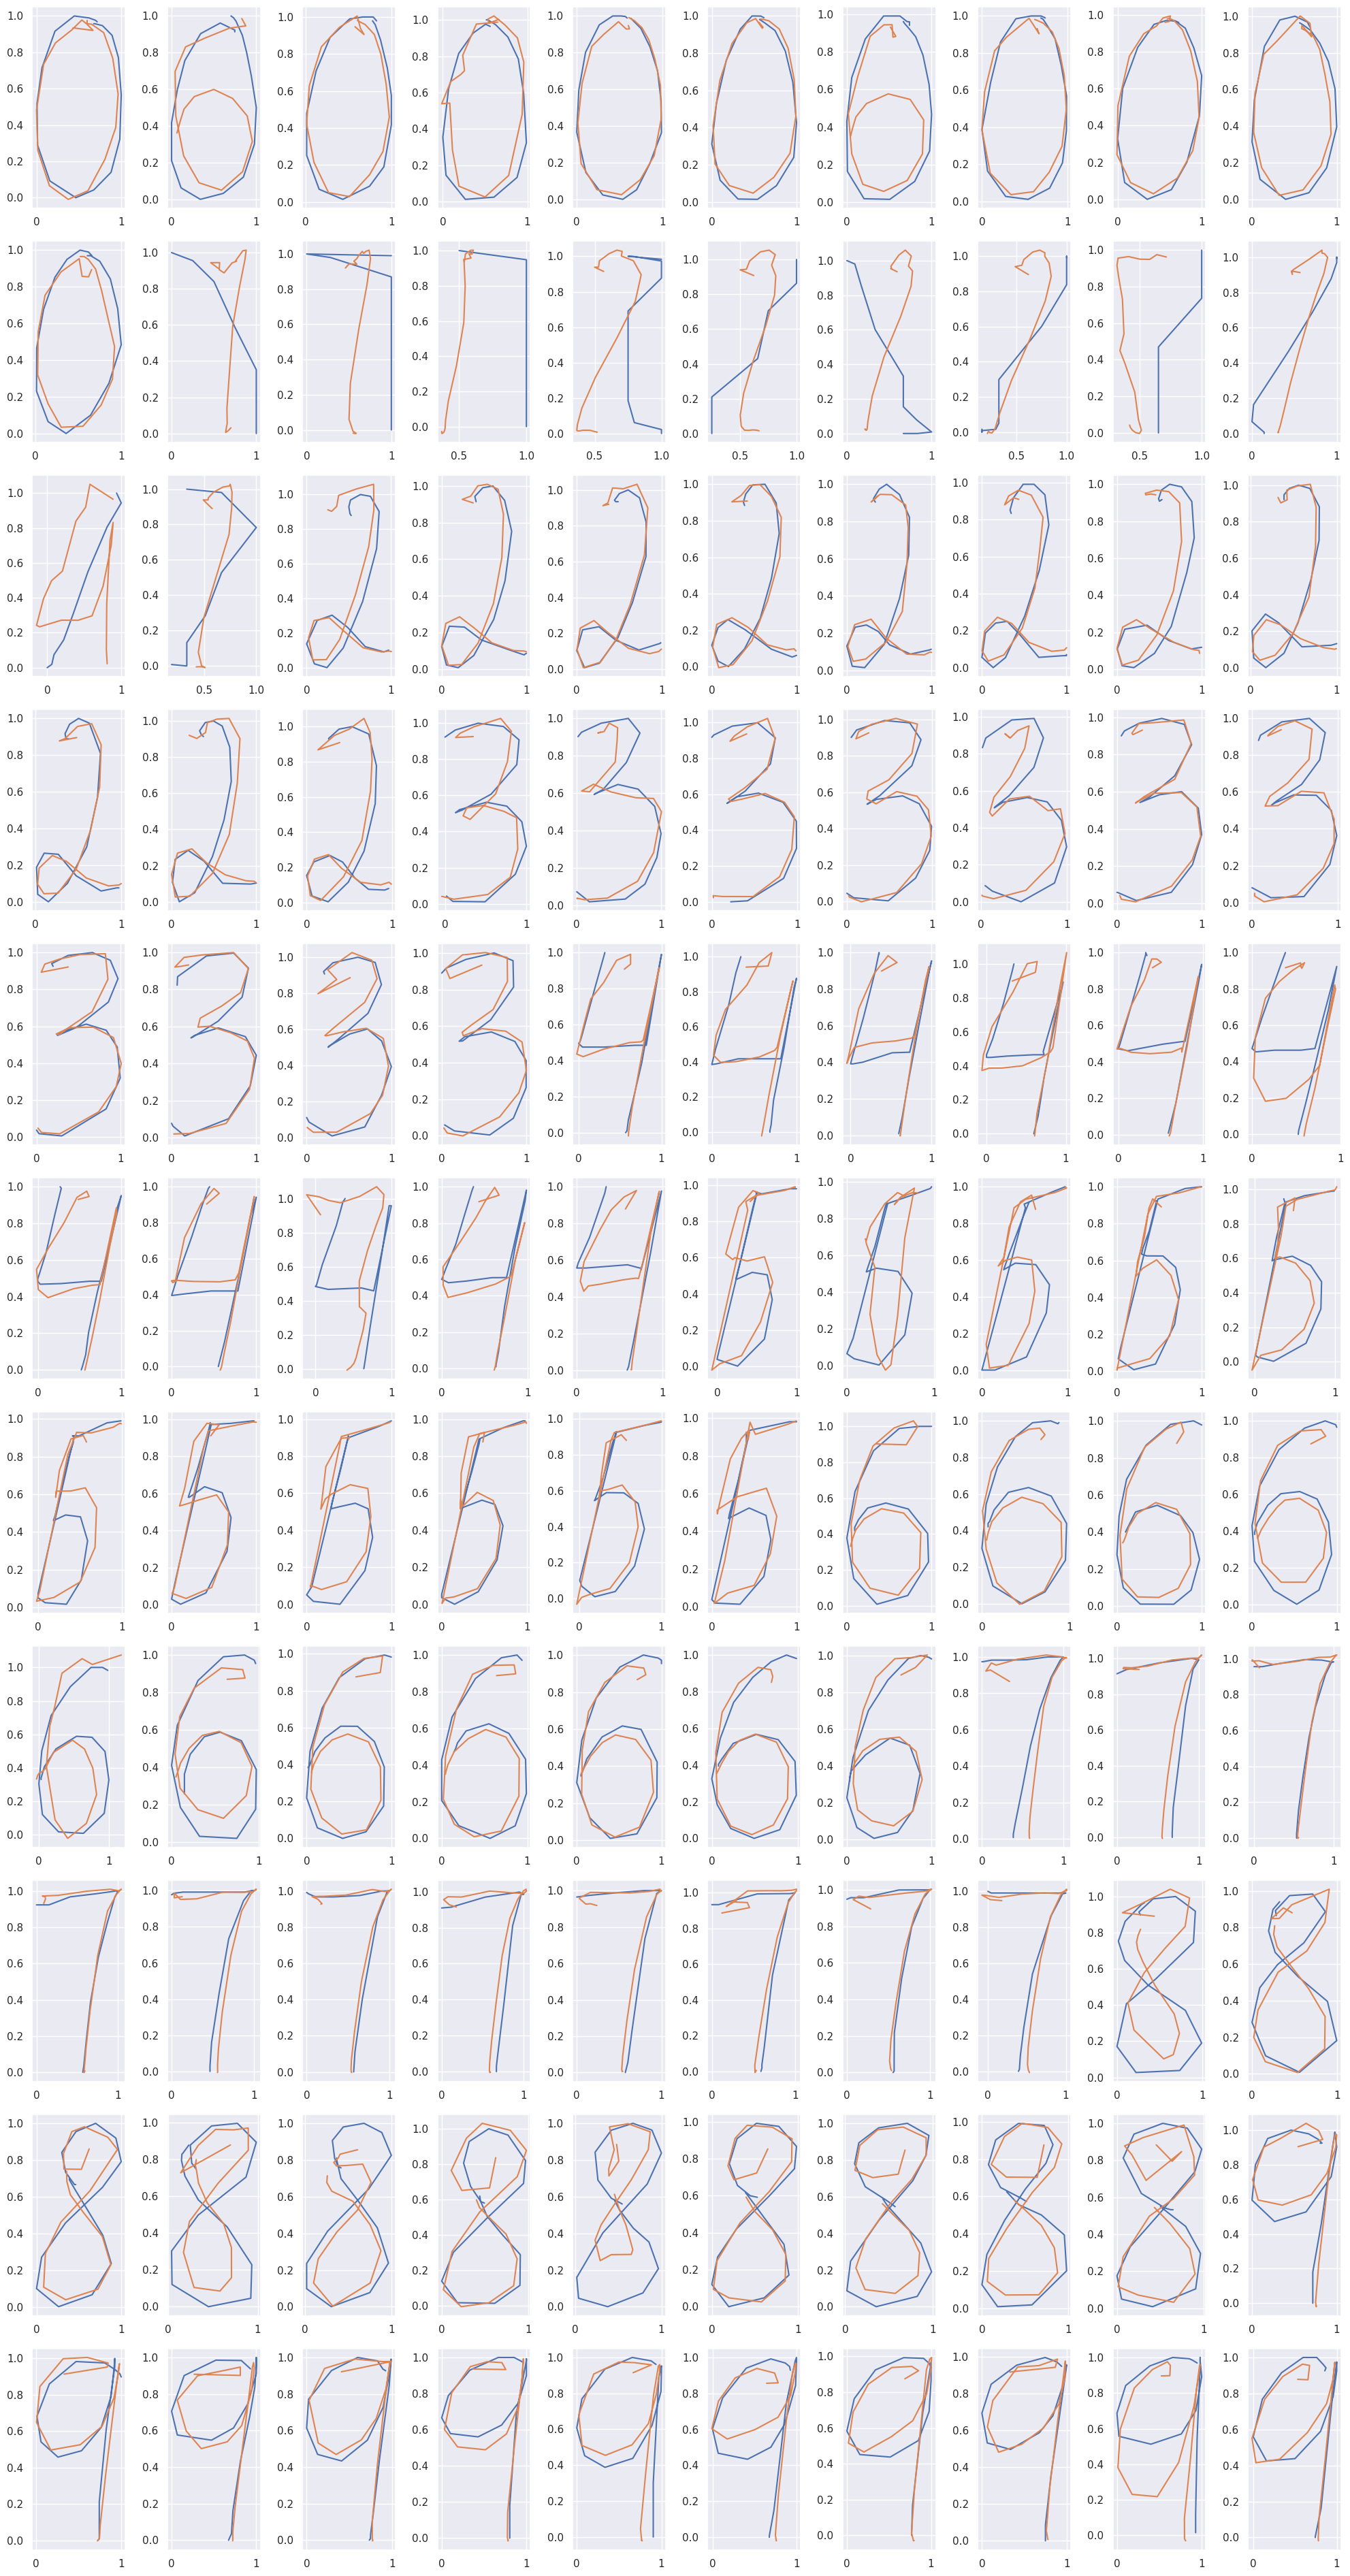

In [12]:
fig, ax = plt.subplots(len(test_loader), 10, figsize=(20, 38))
for i, (X_batch, y_batch) in enumerate(test_loader):
    preds = model.predict(X_batch)
    preds = preds.detach()

    for j, pred in enumerate(preds):
        ax[i, j].plot(y_batch[j, :, 0], y_batch[j, :, 1])
        ax[i, j].plot(pred[:, 0], pred[:, 1])
plt.tight_layout()
plt.savefig("result_lstm.png", dpi=125)

In [13]:
test_loader = model.create_dataloader(test_data, test_pred, batch_size=1, shuffle=False)

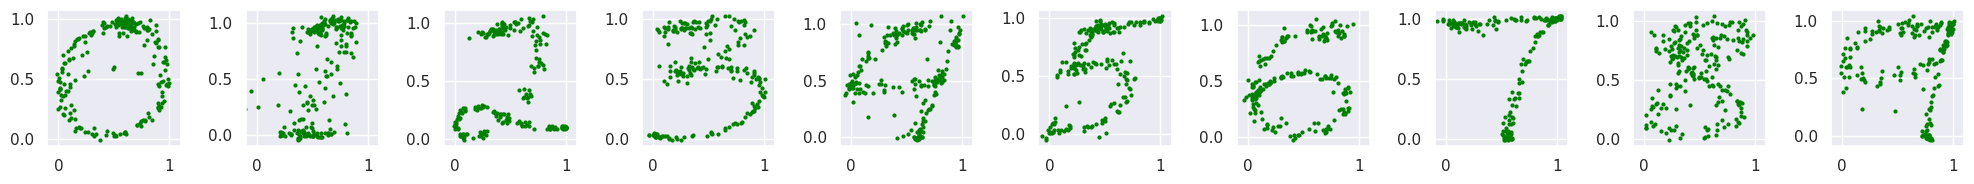

In [14]:
fig, ax = plt.subplots(1, 10, figsize=(20, 2))

index = 0
curr_index = 0

type_check = val_type[::20]

prev_type = 1

for i, (X_batch, y_batch) in enumerate(test_loader):
    if type_check[i] != prev_type:
        index += 1
        prev_type = type_check[i]
    preds = model.predict(X_batch)
    preds = preds.detach()

    # ax[index].plot(y_batch[0, :, 0], y_batch[0, :, 1])
    ax[index].scatter(preds[0, :, 0], preds[0, :, 1], c='green', s=4)

    # if val_type[] != val_type[curr_index]:
    #     index += 1
    ax[index].set_xlim([-0.1, 1.1])
plt.tight_layout()
plt.savefig("lstm_vis.png", dpi=125)